# 0. Load date and import library

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlopen
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Load the data 'Indian_pines', ground truth
data = loadmat('/content/drive/MyDrive/AOS/AOS1/Indian_pines.mat')
data_gt = loadmat('/content/drive/MyDrive/AOS/AOS1/Indian_pines_gt.mat')

im_raw = data['indian_pines']
im_gt = data_gt['indian_pines_gt']

In [12]:
!ls '/content/drive/MyDrive/AOS/AOS1'

Assignment1_Chen_Zhou.ipynb  Indian_pines_gt.mat  Indian_pines.mat  PaviaU.mat


# 1. Linear dimensionality reduction


## 1.1 Principal Componant Analysis - PCA
As a linear and unsurpervised learning, the PCA method aims to find a series of orthogonal directions that maximize the covariance of sample projections. Maximizing the sample covariance makes the information among samples is well preserved, and the orthogonal direction makes the two dimensions have non-repetitive information.
$$max: Var(w^Tx_i) = \frac{1}{n}\sum^{n}_{i=1}(w^Tx_i\,-\,mean(w^Tx_i))^2$$

However, our data has been centered, which means $mean(w^Tx_i)=0\,$, so
$$max:\sum^n_{i=1}(w^Tx_i)^2\,=\,w^TX^TXw$$
where : 
$$\parallel w\parallel^2_2\,=\,1$$
By introducing the SVD decomposition method, we have made it very simple to solve the eigenvalues of the covariance matrix, so one of the benefits of PCA dimensionality reduction is that the solution is very fast to get.

In our case, the three largest projections will be retained in order to display high-dimensional images.


In [13]:
# apply MinMaxScaler on the data which has already been fitted by dimensionality reduction method and use the original data to reshape
def apply_Scaler(im,im_fitted):
    scaler = MinMaxScaler()
    im_scaled = scaler.fit_transform(im_fitted).reshape(im.shape[0],im.shape[1],3)
    return (im_scaled * 255).astype(np.uint8)

Text(0.5, 1.0, 'PCA method for indian_pines')

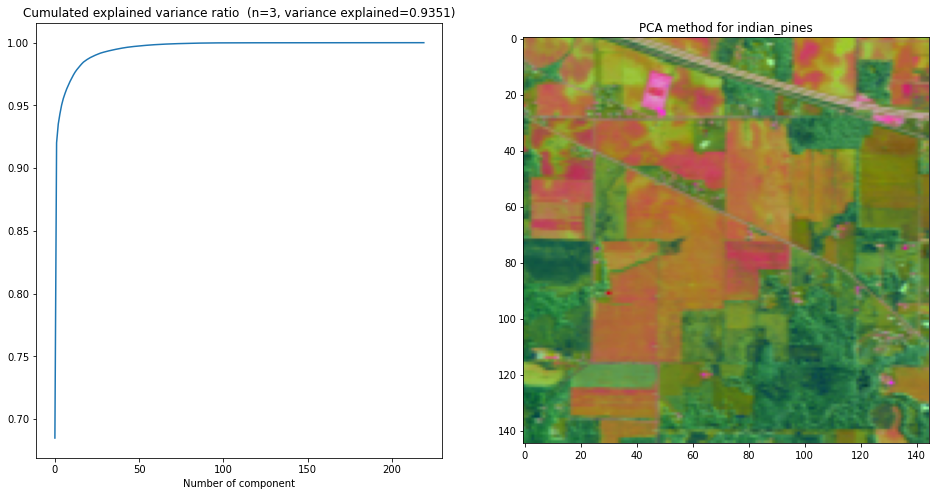

In [14]:
# Unfold image in order to use pca fit method
im_unfold = im_raw.reshape((-1,im_raw.shape[2]))
pca = PCA()
pca.fit(im_raw.reshape((-1,im_raw.shape[2])))

plt.figure(figsize=(16,8))
# plot explained variance ratio - information ratained 
plt.subplot(1,2,1)
plt.plot(range(220), np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulated explained variance ratio  (n=3, variance explained=0.9351)") 
plt.xlabel('Number of component')

# print(np.cumsum(pca.explained_variance_ratio_)[2]) = 0.9351
# Retain the 3 largest principal component and apply scaler function to convert to range[0,255]
im_pca_unfitted = pca.set_params(n_components=3).fit_transform(im_unfold)
im_pca = apply_Scaler(im_raw, im_pca_unfitted)

plt.subplot(1,2,2)
plt.imshow(im_pca)
plt.title("PCA method for indian_pines")


We can note that **93.5%** of variance information was kept by retaining the 3 largest component, so the area where different crops are grown in the image looks well differentiated

## 1.2 Linear Discriminant Analysis - LDA
LDA is a linear and supervised learning method. It aims to find a direction to make same class data as close as possible and different class of data as separate as possible. As a result, instead of maximizing the sample covariance, LDA proposes to maximize the generalized Rayleigh quotient or cost function $J$ :
$$J(w) = \frac{w^T\Sigma_Bw}{w^T\Sigma_ww}$$
where
$ \Sigma_B = \frac{1}{C} \sum_{i=1}^C (\mu_i-\mu) (\mu_i-\mu)^T$
and
$\Sigma_w$ is covariance matrix

In [15]:
def apply_LDA(im_raw,y):
  # Unfold the image shape = (number of sample, number of feature) and ground truth = (number of sample, )
  im_raw = im_raw.reshape((-1,im_raw.shape[2]))
  y = y.reshape(-1,)
  
  # Choose hyper-parameter n_component = 3
  lda = LinearDiscriminantAnalysis(n_components=3)
  im_fitted = lda.fit_transform(im_raw,y)

  # Returun also explained variance when n = 3 
  var_explained = np.cumsum(lda.explained_variance_ratio_)[2]

  return var_explained, im_fitted 

Text(0.5, 1.0, 'PCA method for indian_pines with 93.51% variance explained')

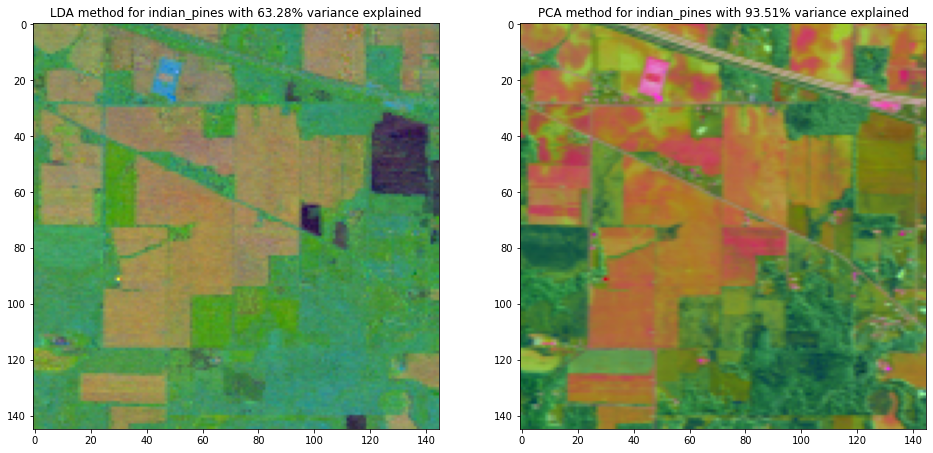

In [16]:
# Apply the lda dimensionality reduction functions and display
var_lda_explained, im_lda_unscaled = apply_LDA(im_raw,im_gt)
im_lda = apply_Scaler(im_raw, im_lda_unscaled)

#plot image processed by LDA:
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(im_lda)
plt.title("LDA method for indian_pines with"+" "+str(round(var_lda_explained*100,2))+"%"+" "+"variance explained")

# plot image processed by PCA
plt.subplot(1,2,2)
plt.imshow(im_pca)
plt.title("PCA method for indian_pines with 93.51% variance explained")

As we can see, the same type of pixels (crops) in the image processed by LDA are very well gathered together, and at the same time, the distinction between different types of crops is also more obvious than PCA. But in terms of the difference between individual pixels, it is more obvious in pictures processed by PCA. 


It reflects the **difference in optimization goals** between these two algorithms. Besides, as we have discussed before, PCA is an unsupervised learning algorithm, it does not take the known class information into account when it choose the direction.

# 2. Non-linear dimensionality reduction
In the previous chapter, only linear combinasion among the features was considered since we use linear model to reduce its dimensionality. However, in order to preserve the image information to the greatest extent, the non-linear informations should not be ignored either(edge, curve...)

In this chapter, the kernal principal componant analysis(KPCA) will be used in order to compare with the linear model.

##Kernel Principal Componant Analysis - KPCA

Kernel PCA first uses the kernel method to map the existing features to higher dimensions espace, and then uses the PCA method to reduce their dimensionality. We can note that we assume that the relationship between high-dimensional features is still linear. 
$$(x_1,x_2...,x_p)\to K(x_1,x_2...,x_p)=(\phi(x_1),\phi(x_2),...\phi(x_p))$$
There are plenty of kernel funtions to choose, and we use polynomial function with 3 degrees
$$K(x,x_i)=(x+x_i+1)^3$$  

In [ ]:
def apply_KPCA(im_raw):
  # Unfold the image shape = (number of sample, number of feature)
  im_raw = im_raw.reshape((-1,im_raw.shape[2]))
  kpca = KernelPCA(n_components=3,kernel='poly',degree=3)

  im_fitted = kpca.fit_transform(im_raw)

  return im_fitted

Text(0.5, 1.0, 'ground truth for indian_pines')

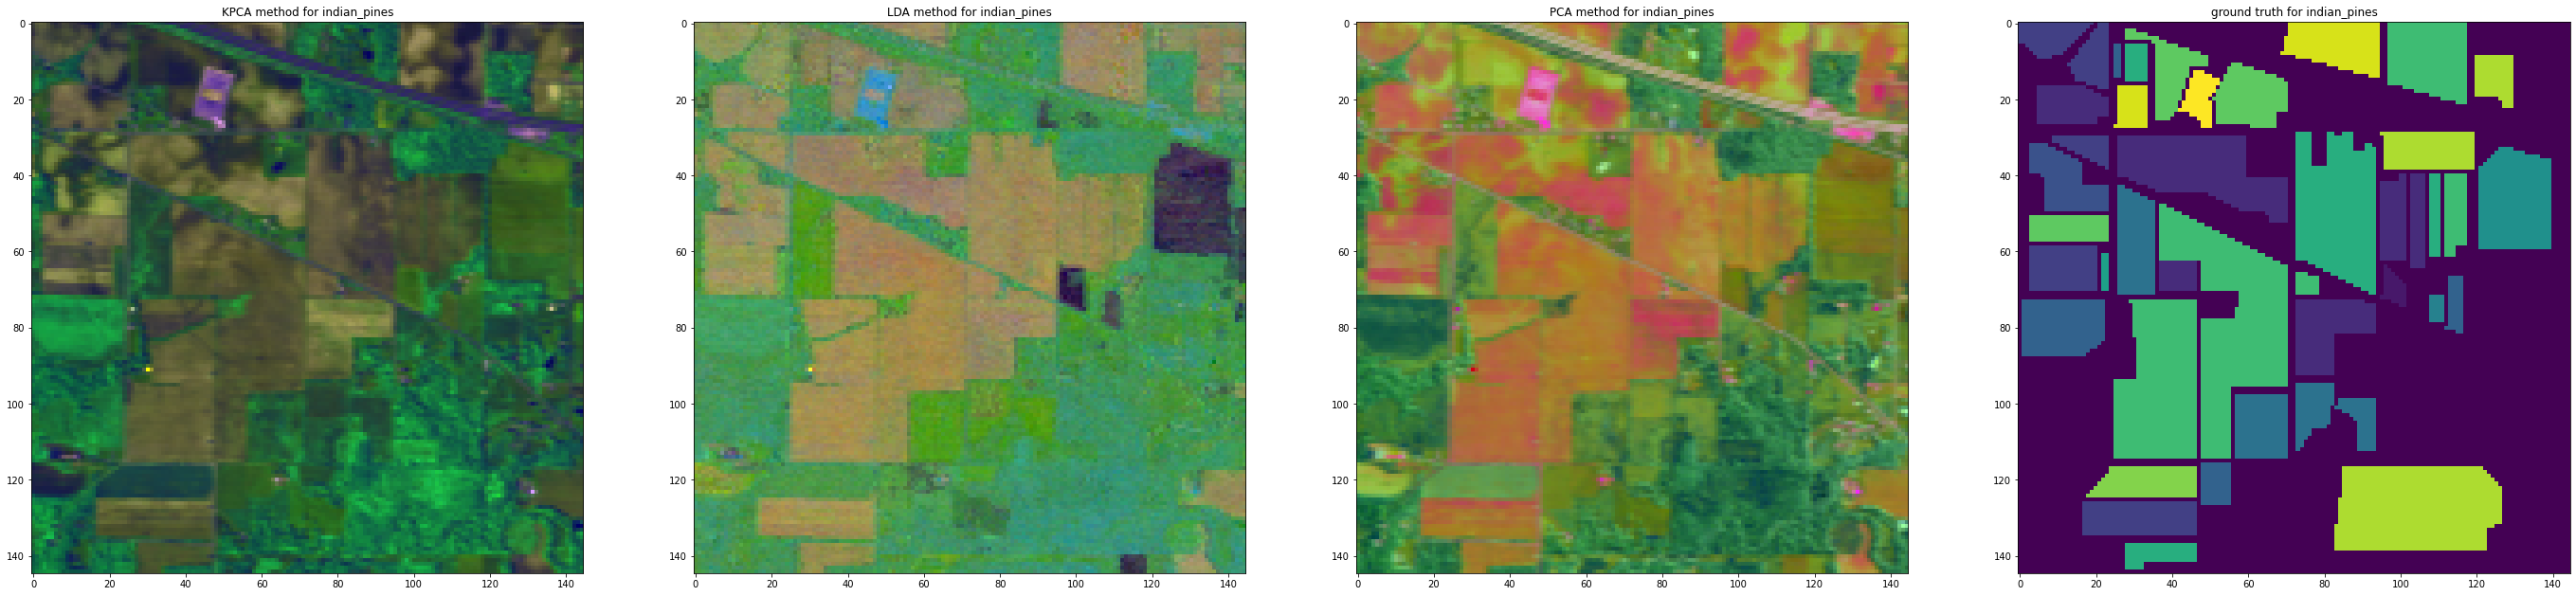

In [ ]:
# Apply KPCA dimensionality reduction
im_kpca = apply_Scaler(im_raw, apply_KPCA(im_raw))

plt.figure(figsize=(48,24))
#plot 1:
plt.subplot(1, 4, 1)
plt.imshow(im_kpca)
plt.title("KPCA method for indian_pines")

#plot 2:
plt.subplot(1, 4, 2)
plt.imshow(im_lda)
plt.title("LDA method for indian_pines")

#plot 3:
plt.subplot(1, 4, 3)
plt.imshow(im_pca)
plt.title("PCA method for indian_pines")

#plot 4:
plt.subplot(1, 4, 4)
plt.imshow(im_gt)
plt.title("ground truth for indian_pines")

Compared with the PCA method, the image processed by KPCA looks easier to determine the type of crop corresponding to the pixel, which can be classified by Maximum Likelihood Classification. However, The resources used to calculate KPCA are much more important than PCA(51s vs 5s). As a result, Even though the classification accurancy of MLC on KPCA image may be better than PCA, KPCA is difficult to be used in practice.

# 3. Conclusion
After comparing the three methods of PCA, LDA and KPCA to reduce the band in multispectral images, we can find that the cumulated explained variance ratio of PCA has reached **0.935**, and the image loss is acceptable, while the Cumulated explained variance ratio of LDA has reached **0.633**.
The application of KPCA will greatly occupy memory consumption, and even cannot be implemented on the website when the picture is too large (even if KPCA can better reduce the loss caused by dimensionality reduction). In conclusion we think that applying PCA on this project to reduce the band is the best way.